In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import depolarizing_error, NoiseModel
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

import numpy as np
import matplotlib.pyplot as plt

import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [3]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [4]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [5]:
# train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_circuits/train/', '.pk')
# print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_circuits/val/', '.pk')
print(len(test_circuits))

  0%|          | 0/10 [00:00<?, ?it/s]

2000


In [17]:
def get_zne_expval(circ,
                   obs: str,
                   extrapolator,
                   backend,
                   noise_factors = [1, 3, 5, 7],
                   amplifier=LocalFoldingAmplifier(gates_to_fold=2),
                   shots:int=10000,
                   ) -> float:
    """Returns the zero-noise expectation values for a list of observables `obs` of a circuit `circ`

    Inputs:
    obs (list[str]): Observables in Endian convention (e.g. 'IIZ' is the Z operator on the 0th qubit) for the PHYSICAL qubits
    mapping (list[int]): Mapping between logical and physical qubits, e.g. mapping[0] is the physical qubit for logical qubit 0

    """
    observable = SparsePauliOp(obs)

    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)

    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors,
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )

    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    result = job.result()
    values = result.values.tolist()

    return values

In [18]:
# test_circuits[0].remove_final_measurements()
# test_circuits[0].measure_active()
# test_circuits[17].draw('mpl', fold=-1)

In [19]:
def get_measurement_qubits(qc, num_qubit):
        measurement_qubits = []
        for measurement in range(num_qubit-1, -1, -1):
            measurement_qubits.append(qc.data[-1-measurement][1][0].index)
        return measurement_qubits

In [20]:
# Debugging confusing results
# 1. The cal_z_exp function mistakenly does NOT use Endian convention -> This means that the `ideal` and `noisy` results needed to be reversed
# 2. The cal_z_exp function returns z expectation values that are off by a factor of -1
# 3. The `get_measurement_qubits` CORRECTLY returns the logical-to-physical qubit mapping
# 4. We always want the logical state of the ancilla qubit to appear last in the array as our convention
# 5.

In [21]:
k = 17
mapping = get_measurement_qubits(test_circuits[k], 4)
# Reverse the order of the mapping
mapping = mapping[::-1]
# Add the ancilla qubit to the end of the mapping
for i in range(5):
    if i not in mapping:
        mapping = mapping + [i]

mapping

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_87705/2271416955.py:4: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  measurement_qubits.append(qc.data[-1-measurement][1][0].index)


[4, 2, 1, 3, 0]

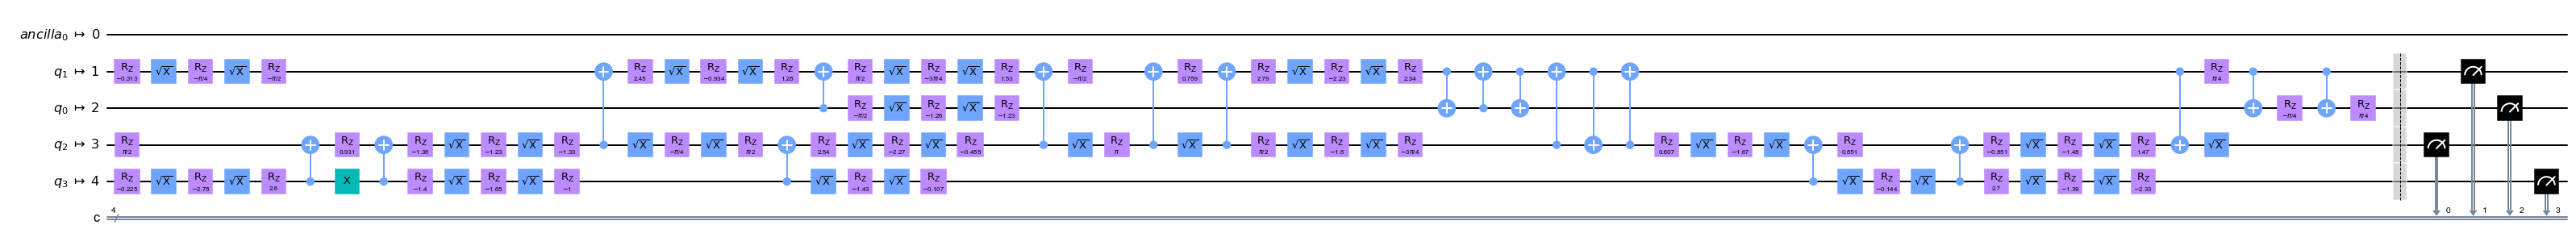

In [22]:
test_circuits[k].draw('mpl', fold=-1)

In [23]:
print(test_ideal_exp_vals[k])
print(test_noisy_exp_vals[k])

[0.0504, -0.3694, -0.0914, -0.0156]
[[-0.0192, -0.3246, -0.1066, -0.0474]]


In [24]:
degree = 2
extrapolator = PolynomialExtrapolator(degree=degree)
mitigated = []
original = []
# ob_list = np.array(['ZIIII' 'IZIII' 'IIZII' 'IIIZI' 'IIIIZ'])
ob_list = np.array(['ZIIII', 'IZIII', 'IIZII', 'IIIZI', 'IIIIZ'][::-1]) # so ob_list has single Z measurement on the first qubit in the last position, i.e., 'ZIIII' is measuring the top qubit (Non-endian notation)
ob_list = ob_list[np.array(mapping)].tolist()
print(ob_list)
for obs in ob_list:
    mitigated += get_zne_expval(test_circuits[k], obs, extrapolator, backend_ideal, noise_factors=[1])
mitigated = [-1*m for m in mitigated] # Flip by negative 1 because cal_z_exp assumes 0 is -Z and 1 is +Z
original = [-1*o for o in original]
print(mitigated)

['ZIIII', 'IIZII', 'IIIZI', 'IZIII', 'IIIIZ']
[0.0668, -0.3564, -0.0796, 0.0092, -1.0]


In [94]:
def cal_z_exp(counts):
    """
        Compute all sigma_z expectations values.

        Parameters
        ----------
        counts : dict
            Dictionary of state labels (keys, e.g. '000', '001')

        Returns
        -------
        z_exp : list of float
            sigma_z expectation values, where len(z_exp) is the number of qubits
        """
    shots = sum(list(counts.values()))
    num_qubits = len(list(counts.keys())[0])
    count_pos_z = np.zeros(num_qubits)  # counts of positive z
    # Convert all keys into arrays
    for key, val in counts.items():
        count_pos_z += val * np.array(list(key), dtype=int)
    count_neg_z = np.ones(num_qubits) * shots - count_pos_z  # counts of negative z
    z_exp = (count_pos_z - count_neg_z) / shots
    # z_exp = z_exp[::-1] # Uncomment this line if assuming `counts` is in Endian convention
    return z_exp

In [96]:
counts = {'00': 1000,
          '10': 1000}
cal_z_exp(counts)

array([ 0., -1.])

In [18]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

degree = 2
extrapolator = PolynomialExtrapolator(degree=degree)
for circ, ideal, noisy in tqdm(zip(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals), total=len(test_circuits)):
    out = []
    for obs in ['IIIZI', 'IIZII', 'IZIII', 'ZIIII']:
        out += get_zne_expval(test_circuits[k], obs, extrapolator, backend).values.tolist()

    ngm_mitigated = out
    imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
    imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
    imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
    for q in range(4):
        ideal_q = ideal[q]
        noisy_q = noisy[q]
        ngm_mitigated_q = ngm_mitigated[q]
        distances.append({
            f"ideal_{q}": ideal_q,
            f"noisy_{q}": noisy_q,
            f"ngm_mitigated_{q}": ngm_mitigated_q,
            f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
            f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
            f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
            f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            "imb_ideal": imbalance_ideal,
            "imb_noisy": imbalance_noisy,
            "imb_ngm": imbalance_mitigated,
            "imb_diff": imbalance_ideal - imbalance_mitigated
        })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

random seed fixed to 0


0it [00:00, ?it/s]

KeyboardInterrupt: 